# Modern Portfolio Theory - Markowitz Simulation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Global Variable RFR
r = 0.04

In [2]:
def get_data(choice):
    while choice not in ['exercice', 'real']:
        choice = input("Input 'exercice' or 'real': ")

    if choice == 'exercice':
        daily_returns = pd.read_csv('resources/MVM_data.csv')
        mus = daily_returns['mu'].set_axis(daily_returns['cov'])
        cov = daily_returns.iloc[:, 2:].set_axis(daily_returns['cov'])
    elif choice == 'real':
        daily_returns = pd.read_csv('resources/daily_returns.csv').set_index('Date')
        daily_returns = daily_returns*100
        mus = daily_returns.mean()
        cov = daily_returns.cov()

    return mus, cov

### Generate Random Basic Portfolios

In [4]:
def generate_random_basic_portfolios(mus, cov):

    np.random.seed(50)
    n_assets = len(cov.columns)
    n_portfolios = 5000
    mean_variance_df = pd.DataFrame(columns=['Mean', 'Std', 'Sharpe Ratio'])

    for p in range(n_portfolios):
        assets = np.random.choice(list(cov.columns), n_assets, replace=False)
        weights = np.random.rand(n_assets)
        weights = weights/sum(weights)

        portfolio_E_Variance = 0
        portfolio_E_Return = 0
        for i in range(len(assets)):
            portfolio_E_Return += weights[i] * mus.loc[assets[i]]
            for j in range(len(assets)):
                portfolio_E_Variance += weights[i] * weights[j] * cov.loc[assets[i], assets[j]]

        new_row = pd.DataFrame({'Mean': portfolio_E_Return,
                                'Std': np.sqrt(portfolio_E_Variance),
                                'Sharpe Ratio': (portfolio_E_Return-r)/np.sqrt(portfolio_E_Variance)},
                                index=[p])
        mean_variance_df = pd.concat([mean_variance_df, new_row])

    return mean_variance_df

### Generate Random RFR Portfolios

In [5]:
def generate_random_RFR_portfolios(mus, cov, r):

    mus['RFR'] = r
    np.random.seed(50)
    n_portfolios = 10000

    mean_variance_df = pd.DataFrame(columns=['Mean', 'Std', 'Sharpe Ratio'])

    for p in range(n_portfolios):
        assets = np.random.choice(list(cov.columns),
                                  len(cov.columns),
                                  replace=False)
        assets = np.append(np.array(['RFR']), assets)
        weights = np.random.rand(len(assets))
        weights = weights/sum(weights)

        portfolio_E_Variance = 0
        portfolio_E_Return = 0
        for i in range(len(assets)):
            portfolio_E_Return += weights[i] * mus.loc[assets[i]]
            for j in range(len(assets)):
                if assets[i] != 'RFR' and assets[j] != 'RFR':
                    portfolio_E_Variance += weights[i] * weights[j] * cov.loc[assets[i], assets[j]]
        sharpe = (portfolio_E_Return-r)/np.sqrt(portfolio_E_Variance)

        new_row = pd.DataFrame({'Mean': portfolio_E_Return,
                                'Std': np.sqrt(portfolio_E_Variance),
                                'Sharpe Ratio': sharpe,
                                'Weights': [weights]},
                                index=[p])
        mean_variance_df = pd.concat([mean_variance_df, new_row])

    return mean_variance_df

### Minimum Variance Frontier

In [6]:
def minimum_variance_frontier(mean_variance_df):
    n_buckets = 10
    mean_variance_df['Mean_Bucket'] = pd.cut(mean_variance_df['Mean'], bins=n_buckets)

    min_std_indices = []
    for _, group in mean_variance_df.groupby('Mean_Bucket'):
        if not group.empty:
            min_std_indices.append(group['Std'].idxmin())
    frontier_df = mean_variance_df.loc[min_std_indices]

    return frontier_df

### Plot Simulation

In [7]:
def plot_simulation(mean_variance_df, frontier_df, mus, cov, title):
    plt.figure(figsize=(12, 8))

    scatter = plt.scatter(mean_variance_df['Std'], mean_variance_df['Mean'], c=mean_variance_df['Sharpe Ratio'], cmap='viridis', alpha=0.8)
    plt.colorbar(scatter, shrink=0.5, aspect=5, label='Sharpe Ratio')

    plt.plot(frontier_df['Std'].to_numpy(), frontier_df['Mean'].to_numpy(), c='red')

    variances = cov.to_numpy().diagonal()
    plt.scatter(np.sqrt(variances), mus, c='black', marker='+', s=100,
                label='Individual Stocks')

    plt.xlabel('Std.')
    plt.ylabel('Expected Returns')
    plt.title(title)
    plt.show()

### Simulation with Exercice Data

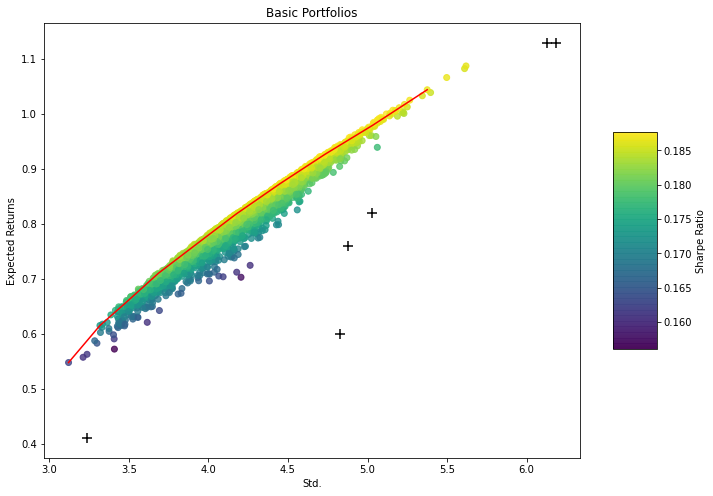

In [8]:
mus, cov = get_data('exercice')
mean_variance_df = generate_random_basic_portfolios(mus, cov)
frontier_df = minimum_variance_frontier(mean_variance_df)
plot_simulation(mean_variance_df, frontier_df, mus, cov, 'Basic Portfolios')

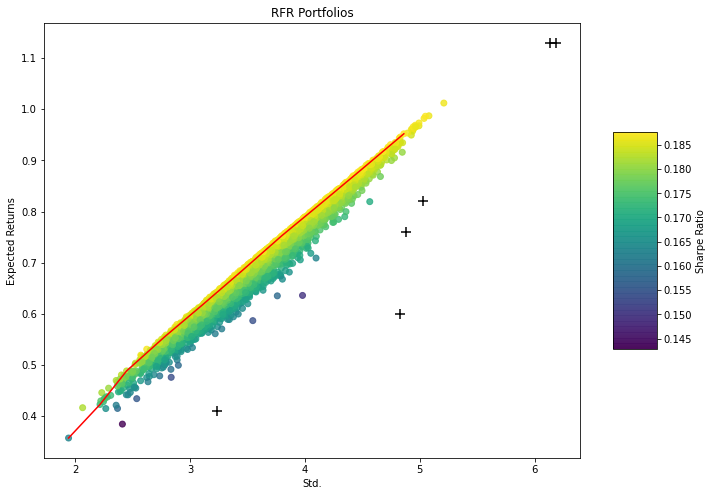

In [9]:
mus, cov = get_data('exercice')
mean_variance_df = generate_random_RFR_portfolios(mus, cov, r)
frontier_df = minimum_variance_frontier(mean_variance_df)
plot_simulation(mean_variance_df, frontier_df,  mus[:-1], cov, 'RFR Portfolios')

### Simulation with Real Data

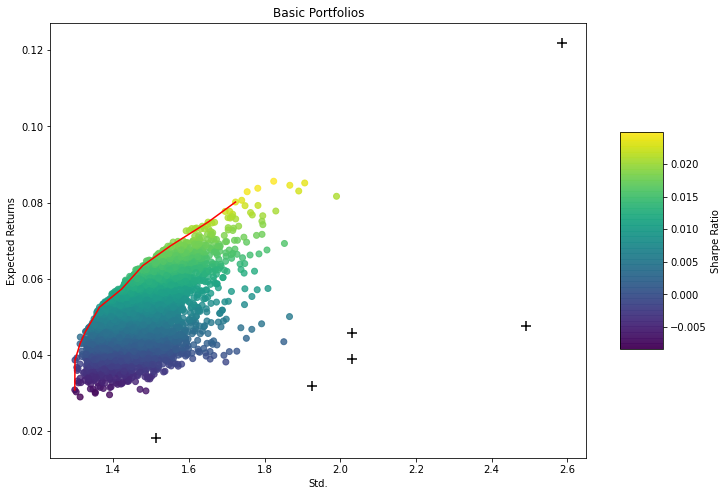

In [10]:
mus, cov = get_data('real')
mean_variance_df = generate_random_basic_portfolios(mus, cov)
frontier_df = minimum_variance_frontier(mean_variance_df)
plot_simulation(mean_variance_df, frontier_df,  mus, cov, 'Basic Portfolios')

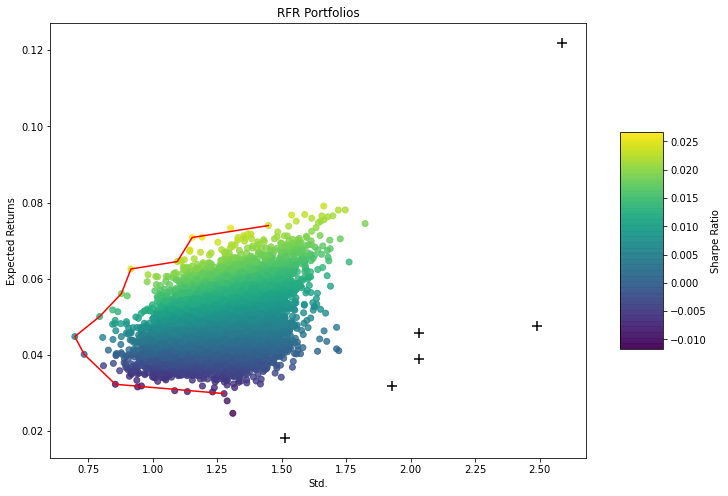

In [11]:
mus, cov = get_data('real')
mean_variance_df = generate_random_RFR_portfolios(mus, cov, r)
frontier_df = minimum_variance_frontier(mean_variance_df)
plot_simulation(mean_variance_df, frontier_df, mus[:-1], cov, 'RFR Portfolios')